<h3 align="center">Automobile Customer Segmentation Analysis - Python</h3> 

##### Overview: Customer segmentation is a marketing term that splits customers into different segments or clusters to understand characterisitics about them (e.g. spending habits, age, gender, income). This concept is very popular in marketing because this helps businesses determine who to specifically target the most for specific products or ads. In this Jupyter Notebook, I will be walking you though a simple and effecitve customer segmentation analysis that focuses on customers in the automobile industry?

##### Tools: The primary tools used in this project are Jupyter Notebook, Python, Plotly, Seaborn, and Sklearn.

##### Dataset Source: https://www.kaggle.com/datasets/akashdeepkuila/automobile-customer. Note: For this demonstration, I will be adding a new column for Annual Income ($), transform the Spending Score into integers from 1-100, and remove a few columns to clean up the dataset.

##### Import all the necessary libaries

In [48]:
import pandas as pd
import s3fs
import datetime
from datetime import date
import numpy as np
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import os
import six
import base64
from IPython.display import display
import plotly.express as px
import calendar
from pytz import timezone
import pytz
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')


##### First, I will connect to my public AWS S3 bucket and convert the stored file into a Pandas dataframe. Note: I am using public access for this example only but it is recommend to keep your S3 bucket private

In [49]:
import pandas as pd
import s3fs

aws_file = pd.read_csv('s3://tims-personal-projects/Customer Segmentation.csv')

customer_seg_df = pd.DataFrame(aws_file)

display(customer_seg_df.head())
display(customer_seg_df.shape)

,CustomerID,Gender,Married,Age,Graduated,Profession,WorkExperience,SpendingScore,FamilySize,Category
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Category 6
1,458994,Male,Yes,37,Yes,Nursing,8.0,Average,4.0,Category 6
2,459000,Male,Yes,59,No,Manager,11.0,High,2.0,Category 6
3,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Category 6
4,459008,Female,Yes,47,Yes,Artist,1.0,Average,3.0,Category 6


(2046, 10)

##### For this step, we are going to clean up the dataset. We are going to remove all the unnamed columns, rename some columns, drop NaN values, convert column data types to integers, and drop a few unneeded columns.

In [50]:
# Remove all the unneeded columns
customer_seg_df.drop(customer_seg_df.columns[customer_seg_df.columns.str.contains(
    'unnamed', case=False)], axis=1, inplace=True)

customer_seg_df.dropna(inplace=True)

# Rename the columns
customer_seg_df_updated = customer_seg_df.rename(
    columns={'WorkExperience': 'Work Experience', 'SpendingScore': 'Spending Score', 'FamilySize': 'Family Size'})

customer_seg_df_updated['Age'] = customer_seg_df_updated[
    'Age'].astype(int)

customer_seg_df_updated['Work Experience'] = customer_seg_df_updated[
    'Work Experience'].astype(int)

customer_seg_df_updated['Family Size'] = customer_seg_df_updated[
    'Family Size'].astype(int)

customer_seg_df_updated_v2 = customer_seg_df_updated.drop(
    columns=['CustomerID', 'Category'])

display(customer_seg_df_updated_v2.head())
display(customer_seg_df_updated_v2.shape)
display(customer_seg_df_updated_v2.info())


,Gender,Married,Age,Graduated,Profession,Work Experience,Spending Score,Family Size
0,Female,Yes,36,Yes,Engineer,0,Low,1
1,Male,Yes,37,Yes,Nursing,8,Average,4
2,Male,Yes,59,No,Manager,11,High,2
4,Female,Yes,47,Yes,Artist,1,Average,3
5,Male,Yes,50,Yes,Artist,2,Average,4


(1694, 8)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1694 entries, 0 to 2045
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Gender           1694 non-null   object
 1   Married          1694 non-null   object
 2   Age              1694 non-null   int32 
 3   Graduated        1694 non-null   object
 4   Profession       1694 non-null   object
 5   Work Experience  1694 non-null   int32 
 6   Spending Score   1694 non-null   object
 7   Family Size      1694 non-null   int32 
dtypes: int32(3), object(5)
memory usage: 99.3+ KB


None

##### Now, we have reduced the number of customers by 399 by removing the NaN values. Removing null values from our dataset is essential because it will optimize the accuracy of our findings.

##### Now that we have a clean dataset, I want to add a new column to determine the Annual Income of the individual customers based on their profession and working experience. In this scenario, I will not focus on the 'Graduated' column because I personally believe that employers care more about an individual's working experience regardless if they graduated or not.

##### According to the data, majority of automobile customers are the professions listed below. Artists seems to be the most common automobile consumers and homemakers seems to be the least common. The list below makes sense because majority of the professions usually need to commute to their jobs. Homemakers tend to stay home so it wouldn't make sense to purchase a vehicle compared to the other professions.

In [51]:
display(customer_seg_df_updated_v2['Profession'].value_counts())

Artist       696
Nursing      337
Engineer     195
Lawyer       173
Manager      147
Marketing     92
Homemaker     54
Name: Profession, dtype: int64

##### The data below is very intersting. Seems like majority of the automobile customers are relatively new to their fields with 1 year of working experience being the most common. Based on thee findings, I would think that majority of automobile customers are within the younger generation.

In [52]:
display(customer_seg_df_updated_v2['Work Experience'].value_counts())

0     559
1     552
8     104
9     102
4      71
2      64
3      61
5      49
7      43
6      40
14     16
11     11
12      8
13      7
10      7
Name: Work Experience, dtype: int64

##### Now, let's determine the Annual income of each customer based on the profession and number of years in working experience. For this analysis, we can classify Entry-Level, Mid-Level, and Senior-Level as the following:

##### Entry-Level: 0-3 years of working experience

##### Mid-Level: 3-5 years of working experience

##### Senior-Level: At least 5 years of working experience

##### According to ZipRecruiter, Indeed, Zippia, and payscale these are the national average salaries per profession and years of working experience. Also, the Homemaker profession will stay constant because the number of working experience does not apply:

| Profession | Entry-Level | Mid-Level | Senior-Level |
| --- | --- | --- | --- |
| Artist | $35,926 | $57,340 | $72,000 |
| Nursing | $59,460 | $80,000 | $86,000 |
| Engineer | $48,750 | $78,180 | $108,743 |
| Lawyer | $52,582 | $84,186 | $144,000 |
| Manager | $47,220 | $83,246 | $118,906 |
| Marketing | $40,466 | $53,158 | $101,320 |
| Homemaker | $26,588 | $26,588  | $26,588 |


##### Now, let's link the salaries to the professions based on their number of working experience and add the new column to the existing customer segmentation dataframe. Let's use the table below:

| Entry-Level | Mid-Level | Senior-Level |
| --- | ---  | --- |
| 1-3 years | 3-5 years | Beyond 5 years |

In [53]:
def annual_income(customer_seg_df_updated_v2):
    if (customer_seg_df_updated_v2['Profession'] == 'Artist') & (customer_seg_df_updated_v2['Work Experience'] < 3):
        return '36'
    elif (customer_seg_df_updated_v2['Profession'] == 'Nursing') & (customer_seg_df_updated_v2['Work Experience'] < 3):
        return '59'
    elif (customer_seg_df_updated_v2['Profession'] == 'Engineer') & (customer_seg_df_updated_v2['Work Experience'] < 3):
        return '49'
    elif (customer_seg_df_updated_v2['Profession'] == 'Lawyer') & (customer_seg_df_updated_v2['Work Experience'] < 3):
        return '53'
    elif (customer_seg_df_updated_v2['Profession'] == 'Manager') & (customer_seg_df_updated_v2['Work Experience'] < 3):
        return '47'
    elif (customer_seg_df_updated_v2['Profession'] == 'Marketing') & (customer_seg_df_updated_v2['Work Experience'] < 3):
        return '40'
    elif (customer_seg_df_updated_v2['Profession'] == 'Homemaker') & (customer_seg_df_updated_v2['Work Experience'] < 3):
        return '27'
    elif (customer_seg_df_updated_v2['Profession'] == 'Artist') & (customer_seg_df_updated_v2['Work Experience'] >= 3) & (customer_seg_df_updated_v2['Work Experience'] <= 5):
        return '57'
    elif (customer_seg_df_updated_v2['Profession'] == 'Nursing') & (customer_seg_df_updated_v2['Work Experience'] >= 3) & (customer_seg_df_updated_v2['Work Experience'] <= 5):
        return '80'
    elif (customer_seg_df_updated_v2['Profession'] == 'Engineer') & (customer_seg_df_updated_v2['Work Experience'] >= 3) & (customer_seg_df_updated_v2['Work Experience'] <= 5):
        return '78'
    elif (customer_seg_df_updated_v2['Profession'] == 'Lawyer') & (customer_seg_df_updated_v2['Work Experience'] >= 3) & (customer_seg_df_updated_v2['Work Experience'] <= 5):
        return '84'
    elif (customer_seg_df_updated_v2['Profession'] == 'Manager') & (customer_seg_df_updated_v2['Work Experience'] >= 3) & (customer_seg_df_updated_v2['Work Experience'] <= 5):
        return '83'
    elif (customer_seg_df_updated_v2['Profession'] == 'Marketing') & (customer_seg_df_updated_v2['Work Experience'] >= 3) & (customer_seg_df_updated_v2['Work Experience'] <= 5):
        return '53'
    elif (customer_seg_df_updated_v2['Profession'] == 'Homemaker') & (customer_seg_df_updated_v2['Work Experience'] >= 3) & (customer_seg_df_updated_v2['Work Experience'] <= 5):
        return '27'
    elif (customer_seg_df_updated_v2['Profession'] == 'Artist') & (customer_seg_df_updated_v2['Work Experience'] > 5):
        return '72'
    elif (customer_seg_df_updated_v2['Profession'] == 'Nursing') & (customer_seg_df_updated_v2['Work Experience'] > 5):
        return '86'
    elif (customer_seg_df_updated_v2['Profession'] == 'Engineer') & (customer_seg_df_updated_v2['Work Experience'] > 5):
        return '109'
    elif (customer_seg_df_updated_v2['Profession'] == 'Lawyer') & (customer_seg_df_updated_v2['Work Experience'] > 5):
        return '144'
    elif (customer_seg_df_updated_v2['Profession'] == 'Manager') & (customer_seg_df_updated_v2['Work Experience'] > 5):
        return '119'
    elif (customer_seg_df_updated_v2['Profession'] == 'Marketing') & (customer_seg_df_updated_v2['Work Experience'] > 5):
        return '101'
    elif (customer_seg_df_updated_v2['Profession'] == 'Homemaker') & (customer_seg_df_updated_v2['Work Experience'] > 5):
        return '27'


##### Great! The new column is added

In [54]:
customer_seg_df_updated_v2['Annual Salary ($K)'] = customer_seg_df_updated_v2.apply(annual_income, axis = 1)

display(customer_seg_df_updated_v2.head(10))

,Gender,Married,Age,Graduated,Profession,Work Experience,Spending Score,Family Size,Annual Salary ($K)
0,Female,Yes,36,Yes,Engineer,0,Low,1,49
1,Male,Yes,37,Yes,Nursing,8,Average,4,86
2,Male,Yes,59,No,Manager,11,High,2,119
4,Female,Yes,47,Yes,Artist,1,Average,3,36
5,Male,Yes,50,Yes,Artist,2,Average,4,36
6,Male,No,19,No,Nursing,0,Low,4,59
7,Male,No,22,No,Nursing,0,Low,3,59
8,Female,No,22,No,Nursing,0,Low,6,59
9,Male,Yes,50,Yes,Artist,1,Average,5,36
10,Male,No,27,No,Nursing,8,Low,3,86


##### Now, let's convert the 'Spending Score' column to a number scale using a random number generator. 1-33 represents the customers with the lowest spending score, 33-66 represents customers with an average spending score, and 66-99 represents customers with a high spending score.

| Low | Average | High |
| --- | ---  | --- |
| 1-33 | 33-66| 66-99 |

In [55]:
import random

low = random.randint(1,33)
average = random.randint(33, 66)
high = random.randint(66,99)

def spending_score(customer_seg_df_updated_v2):
    if (customer_seg_df_updated_v2['Spending Score'] == 'Low'):
        return low
    elif (customer_seg_df_updated_v2['Spending Score'] == 'Average'):
        return average
    elif (customer_seg_df_updated_v2['Spending Score'] == 'High'):
        return high


##### Append the spending scores to the existing dataframe.

In [56]:
customer_seg_df_updated_v2['Spending Score (1-100)'] = customer_seg_df_updated_v2.apply(spending_score, axis = 1)

display(customer_seg_df_updated_v2.head(10))

,Gender,Married,Age,Graduated,Profession,Work Experience,Spending Score,Family Size,Annual Salary ($K),Spending Score (1-100)
0,Female,Yes,36,Yes,Engineer,0,Low,1,49,12
1,Male,Yes,37,Yes,Nursing,8,Average,4,86,63
2,Male,Yes,59,No,Manager,11,High,2,119,87
4,Female,Yes,47,Yes,Artist,1,Average,3,36,63
5,Male,Yes,50,Yes,Artist,2,Average,4,36,63
6,Male,No,19,No,Nursing,0,Low,4,59,12
7,Male,No,22,No,Nursing,0,Low,3,59,12
8,Female,No,22,No,Nursing,0,Low,6,59,12
9,Male,Yes,50,Yes,Artist,1,Average,5,36,63
10,Male,No,27,No,Nursing,8,Low,3,86,12


##### Let's remove the unneeded 'Spending Score' column and create a final dataframe for Exploratory Data Analysis.

In [57]:
customer_seg_df_updated_v3 = customer_seg_df_updated_v2.drop(
    columns=['Spending Score'])

display(customer_seg_df_updated_v3)

,Gender,Married,Age,Graduated,Profession,Work Experience,Family Size,Annual Salary ($K),Spending Score (1-100)
0,Female,Yes,36,Yes,Engineer,0,1,49,12
1,Male,Yes,37,Yes,Nursing,8,4,86,63
2,Male,Yes,59,No,Manager,11,2,119,87
4,Female,Yes,47,Yes,Artist,1,3,36,63
5,Male,Yes,50,Yes,Artist,2,4,36,63
...,...,...,...,...,...,...,...,...,...
2041,Female,No,19,No,Nursing,0,3,59,12
2042,Male,No,21,No,Nursing,1,4,59,12
2043,Male,No,29,No,Nursing,9,4,86,12
2044,Male,Yes,47,Yes,Manager,1,5,47,87


##### Findings: Based on the dataframe above, I found something interesting. One of the customers with a 99 spending score has one of the highest salaries with 11 years of working experience but no degree. This proves how companies are starting to value more work experience over education!

##### Since we have the dataframe we need, we want to reduce the number of customers to a sample size because 1,694 customers is a lot to analyze and process. Let's figure out the sample size of an infinite population by using the formula below with these variables and a Margin of Error of 5%:

<h5 align="center">z score = 1.96, P=0.50, MOE=0.05</h5> 

##### Sample Size of Infinite Population: 

\begin{equation}
Infinite = 1.96^2 * 0.50 * \frac{(1-0.50)}{(0.05^2)} = 384
\end{equation}

##### Then we adjust the formula to account for 1694 customers in the dataframe.

\begin{equation}
Sample = \frac{384} {1+\frac{(384-1)} {1694}} = 314
\end{equation}

#### Great! We can now reduce our sample size to 314 customers in our dataframe.

In [58]:
customer_seg_df_updated_sample_size = customer_seg_df_updated_v3.head(314)

customer_seg_df_updated_sample_size['Annual Salary ($K)'] = customer_seg_df_updated_sample_size['Annual Salary ($K)'].astype(int)
customer_seg_df_updated_sample_size['Spending Score (1-100)'] = customer_seg_df_updated_sample_size['Spending Score (1-100)'] .astype(int)

print("(Number of Rows, Number of Columns)")
display(customer_seg_df_updated_sample_size.shape)
display(customer_seg_df_updated_sample_size.count())
display(customer_seg_df_updated_sample_size.head())

(Number of Rows, Number of Columns)


(314, 9)

Gender                    314
Married                   314
Age                       314
Graduated                 314
Profession                314
Work Experience           314
Family Size               314
Annual Salary ($K)        314
Spending Score (1-100)    314
dtype: int64

,Gender,Married,Age,Graduated,Profession,Work Experience,Family Size,Annual Salary ($K),Spending Score (1-100)
0,Female,Yes,36,Yes,Engineer,0,1,49,12
1,Male,Yes,37,Yes,Nursing,8,4,86,63
2,Male,Yes,59,No,Manager,11,2,119,87
4,Female,Yes,47,Yes,Artist,1,3,36,63
5,Male,Yes,50,Yes,Artist,2,4,36,63


##### Let's Start Analyzing!

##### Here is the correlation between Age, Work Experience, Family Size, Annual Salary, and Spending Score

,Age,Work Experience,Family Size,Annual Salary ($K),Spending Score (1-100)
Age,1.000000,-0.249805,-0.295929,-0.241696,0.421766
Work Experience,-0.249805,1.000000,-0.002767,0.694124,-0.115138
Family Size,-0.295929,-0.002767,1.000000,0.208102,0.167379
Annual Salary ($K),-0.241696,0.694124,0.208102,1.000000,-0.030905
Spending Score (1-100),0.421766,-0.115138,0.167379,-0.030905,1.000000


<AxesSubplot:>

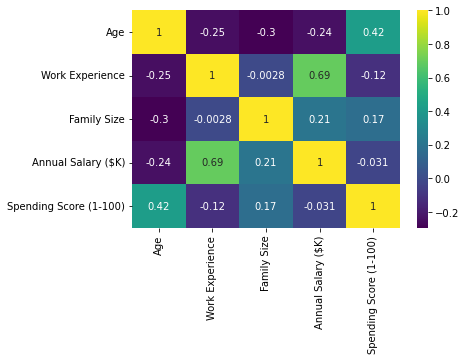

In [59]:
display(customer_seg_df_updated_sample_size.corr())

sns.heatmap(customer_seg_df_updated_sample_size.corr(), annot=True, cmap='viridis')

##### Findings: 

##### A customer's Spending Score is heavily weighted based on their age.
##### Customers with more working experience tend to have higher annual salaries.
##### The spending score seems to be impacted by the family size. This makes sense because more money is probably being spent taking care of family members instead of one individual (e.g. Education, Food, Clothes, Medical Expenses).

##### Here is a pairplot to show the correlation of some columns with graphs based on Profession.

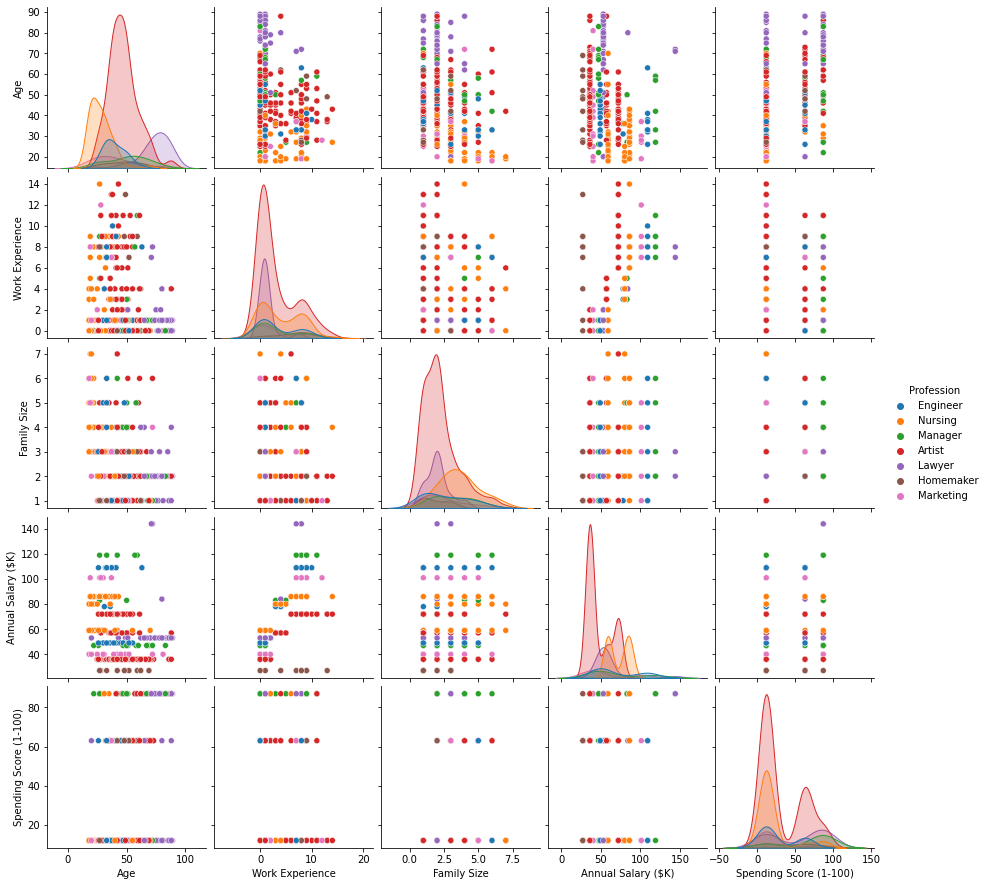

In [60]:
sns.pairplot(customer_seg_df_updated_sample_size, hue="Profession")

##### Analysis Based on Gender:

##### Now, let's start to analyze the correlation between female and male customers. According to the new dataset, there is almost an equal distribution of females and males. However, tere are only 4 more females in this dataset.

Female    159
Male      155
Name: Gender, dtype: int64

[Text(0.5, 1.0, 'Count of Females vs Males')]

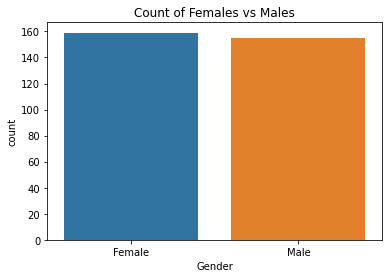

In [61]:
display(customer_seg_df_updated_sample_size['Gender'].value_counts())

sns.countplot(customer_seg_df_updated_sample_size['Gender']).set(title='Count of Females vs Males')

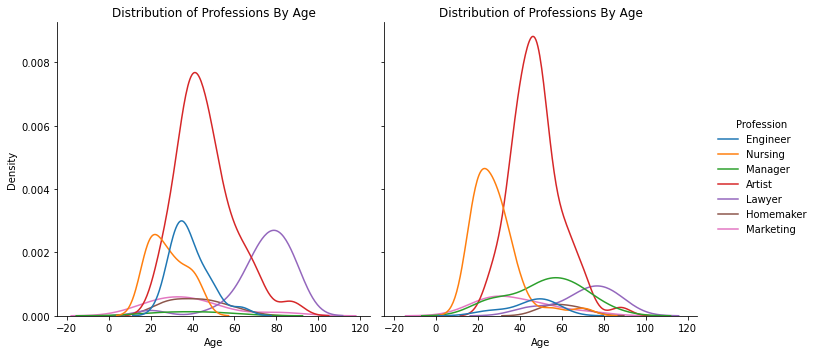

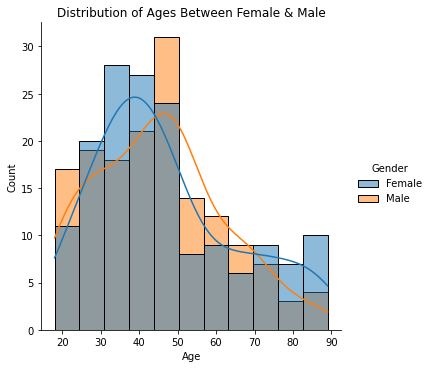

In [62]:
sns.displot(data=customer_seg_df_updated_sample_size, x="Age", hue="Profession", col="Gender", kind="kde").set(title='Distribution of Professions By Age')

fig = px.density_heatmap(customer_seg_df_updated_sample_size, x="Age", y="Gender", text_auto=True)

fig.update_layout(title_text='Count of Individuals Based on Age & Gender', title_x=0.5)

fig.show()

sns.displot(data=customer_seg_df_updated_sample_size, x="Age", hue="Gender", kde=True).set(title='Distribution of Ages Between Female & Male')


##### Findings:

##### 1. Majority of both genders are Artists as a profession.

##### 2. The second highest profession for females are Engineers and the second highest profession for males are Nursing.

##### 3. Majority of both females and males fall between ages 20 to 60 years old according to the distribution. This makes sense because individuals within this age group are usually at a life stage where they've either graduated from school and started working, spent several years working, or raising a family where transportation is very important.

##### 4. Based on the analysis so far, I think it's logical to say that automobile companies should start to target individuals who are Artists and fall between the age ranges of 20 to 60 years old.

##### Here are more findings.

In [63]:
import plotly.express as px

fig = px.density_heatmap(customer_seg_df_updated_sample_size, x="Annual Salary ($K)", y="Gender", text_auto=True)

fig.update_layout(title_text='Count of Individuals Based on Gender & Annual Salary', title_x=0.5)

fig.show()

print('Findings: Majority of Females and Males make an annual salary between $20,000 and $60,000.')

fig = px.density_heatmap(customer_seg_df_updated_sample_size, x="Spending Score (1-100)", y="Profession", text_auto=True)

fig.update_layout(title_text='Count of Individuals Based on Spending Score & Profession', title_x=0.5)

fig.show()

print('Findings: Majority of individuals are Artists but they have the lowest spending score in the group.')

fig = px.density_heatmap(customer_seg_df_updated_sample_size, x="Age", y="Spending Score (1-100)", text_auto=True)

fig.update_layout(title_text='Count of Individuals Based on Spending Score & Age', title_x=0.5)

fig.show()

print('Findings: Majority of Artists are betwen 20 and 60 years old.')

Findings: Majority of Females and Males make an annual salary between $20,000 and $60,000.


Findings: Majority of individuals are Artists but they have the lowest spending score in the group.


Findings: Majority of Artists are betwen 20 and 60 years old.


##### We now know the demographic that the automobile companies should target for ads and products. However, it seems like the spending score for Artists between ages 20 to 60 years old is relatively low (i.e. not past 30). This may be because Artists are more hesitant to purchase vehicles because they aren't making enough money at their stage compared to Lawyers or Engineers. 

##### So, I would advice the automobile companies to strategize a way to tailer their products and ads differently to appeal closer to this audience. For example, sell cars that are more affordable and create ads with celebrities that they can relate too.


##### Now, let's finish this analysis by building a clustering model to distinguish the different customers into groups. This is using a K Means machine learning model which is very popular because this model has an easier time identifying outliers and finds specific data that wasn't easily labeled.

##### First, we startdize the data to remove the mean and scale each variable to a unit variance (i.e. divide each value by the standard deviation). This method will help normalize the data into a particular rang and speed up the model.

In [64]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_seg_df_updated_sample_size[['Age', 'Annual Salary ($K)', 'Spending Score (1-100)']])

print(scaled_data)

[[-0.55574773 -0.3229599  -0.71915378]
 [-0.49936492  1.33948942  0.94773413]
 [ 0.74105682  2.82221448  1.73215197]
 [ 0.06446314 -0.90706371  0.94773413]
 [ 0.23361156 -0.90706371  0.94773413]
 [-1.51425544  0.12635073 -0.71915378]
 [-1.34510702  0.12635073 -0.71915378]
 [-1.34510702  0.12635073 -0.71915378]
 [ 0.23361156 -0.90706371  0.94773413]
 [-1.06319298  1.33948942 -0.71915378]
 [ 0.85382243 -0.90706371 -0.71915378]
 [-1.45787263 -0.14323565  0.94773413]
 [-0.04830247 -0.90706371  0.94773413]
 [ 0.5155256   0.71045454 -0.71915378]
 [ 2.37615821 -0.14323565  0.94773413]
 [-0.21745089 -0.90706371 -0.71915378]
 [-0.61213053  1.33948942  1.73215197]
 [-1.06319298  1.20469623  1.73215197]
 [-0.95042737  0.12635073 -0.71915378]
 [ 1.86871295 -0.14323565  1.73215197]
 [ 2.43254102 -0.14323565 -0.71915378]
 [-0.83766176 -0.90706371 -0.71915378]
 [ 1.47403331 -0.90706371  0.94773413]
 [ 0.85382243  0.71045454 -0.71915378]
 [ 0.91020524 -0.90706371 -0.71915378]
 [ 0.5719084  -0.90706371

##### Here, we categorize the scaled data into different cluster groups (i.e. 0-2).

In [65]:
clusters = 3
model = KMeans(init = 'k-means++', 
               n_clusters = clusters, 
               n_init = 12)
model.fit(scaled_data)

labels = model.labels_
print(labels)

[2 0 0 1 1 0 0 0 1 0 2 0 1 2 1 2 0 0 0 1 2 2 1 2 2 1 1 1 0 0 1 1 1 1 0 1 1
 1 2 2 1 0 1 1 1 2 1 0 1 1 1 2 2 1 1 1 0 1 1 2 2 1 0 2 0 1 1 2 2 2 1 0 2 2
 2 0 1 2 1 1 2 2 2 1 1 2 1 1 1 2 1 1 1 1 2 1 0 2 2 2 1 1 0 2 2 2 1 1 2 2 2
 1 0 1 2 1 0 2 1 0 0 2 0 1 1 2 1 0 2 1 0 0 1 1 0 1 0 1 2 2 1 2 0 2 0 2 0 0
 2 2 0 1 2 1 1 1 0 0 2 0 1 1 0 2 0 2 2 2 0 1 1 0 2 1 2 2 2 0 2 2 1 0 2 1 2
 0 0 2 0 2 2 2 2 2 2 2 2 2 0 2 2 2 2 0 0 1 1 2 2 0 2 2 1 1 1 0 2 0 2 2 0 0
 0 1 0 0 1 1 0 2 2 0 0 1 0 0 0 2 2 1 2 0 2 2 1 2 0 0 0 0 2 0 1 2 2 0 2 2 2
 0 2 0 0 0 0 0 0 0 0 2 0 0 2 0 2 0 0 2 1 2 0 0 0 0 2 1 0 1 1 2 0 1 1 1 0 2
 2 2 2 0 0 2 2 0 2 2 0 0 2 1 2 2 0 0]


##### Now, we have assigned each gender a cluster number based on the model.

In [66]:
customer_seg_df_updated_sample_size['cluster_num'] = labels
customer_seg_df_updated_sample_size.head()

,Gender,Married,Age,Graduated,Profession,Work Experience,Family Size,Annual Salary ($K),Spending Score (1-100),cluster_num
0,Female,Yes,36,Yes,Engineer,0,1,49,12,2
1,Male,Yes,37,Yes,Nursing,8,4,86,63,0
2,Male,Yes,59,No,Manager,11,2,119,87,0
4,Female,Yes,47,Yes,Artist,1,3,36,63,1
5,Male,Yes,50,Yes,Artist,2,4,36,63,1


##### Here is a scatterplot to show where each customer stands.= based on age and spending score.

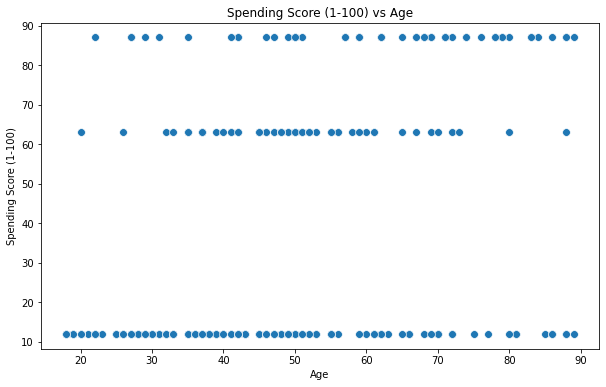

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.scatterplot(x = 'Age',y = 'Spending Score (1-100)',  data = customer_seg_df_updated_sample_size  ,s = 60 )
plt.xlabel('Age')
plt.ylabel('Spending Score (1-100)') 
plt.title('Spending Score (1-100) vs Age')
plt.show()

##### Import K Means from SKlearn.

In [68]:
#Importing KMeans from sklearn
from sklearn.cluster import KMeans

##### Let's seperate each customer into 3 clusters based on a low, average, and high spending score and give them labels.

In [73]:
#Taking 5 clusters
km1=KMeans(n_clusters=3)
#Fitting the input data
km1.fit(scaled_data)
#predicting the labels of the input data
y=km1.predict(scaled_data)
#adding the labels to a column named label
customer_seg_df_updated_sample_size["Cluster"] = y

display(customer_seg_df_updated_sample_size.head())

,Gender,Married,Age,Graduated,Profession,Work Experience,Family Size,Annual Salary ($K),Spending Score (1-100),cluster_num,label,Cluster
0,Female,Yes,36,Yes,Engineer,0,1,49,12,2,2,0
1,Male,Yes,37,Yes,Nursing,8,4,86,63,0,1,1
2,Male,Yes,59,No,Manager,11,2,119,87,0,1,1
4,Female,Yes,47,Yes,Artist,1,3,36,63,1,0,2
5,Male,Yes,50,Yes,Artist,2,4,36,63,1,0,2


##### Now, this scatterplot is organized into the 3 clusters.

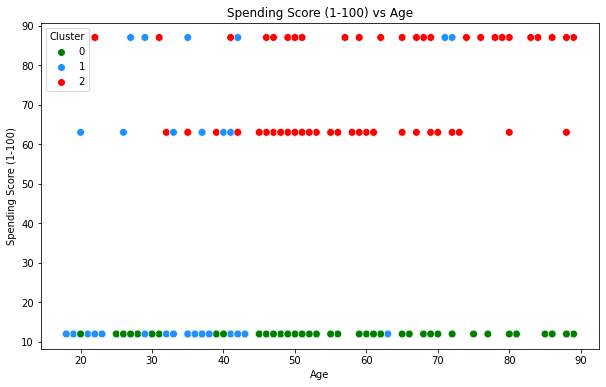

In [74]:
#Scatterplot of the clusters
plt.figure(figsize=(10,6))
sns.scatterplot(x = 'Age',y = 'Spending Score (1-100)',hue="Cluster",  
                 palette=['green','dodgerblue','red'], legend='full', data = customer_seg_df_updated_sample_size  ,s = 60 )
plt.xlabel('Age')
plt.ylabel('Spending Score (1-100)') 
plt.title('Spending Score (1-100) vs Age')
plt.show()

##### This is our final dataframe and heatmap with the K Means machine learning model included.

In [75]:
#The new dataframe with the clustering done

display(customer_seg_df_updated_sample_size.head(10))

df = pd.DataFrame(customer_seg_df_updated_sample_size)

fig = px.density_heatmap(df, x="Age", y="Profession", text_auto=True)

fig.update_layout(title_text='Count of Individuals Based on Age and Profession After Testing The K Means Machine Learning Model', title_x=0.5)

fig.show()

print('Artists have the most spending scores out of each customer.')

,Gender,Married,Age,Graduated,Profession,Work Experience,Family Size,Annual Salary ($K),Spending Score (1-100),cluster_num,label,Cluster
0,Female,Yes,36,Yes,Engineer,0,1,49,12,2,2,0
1,Male,Yes,37,Yes,Nursing,8,4,86,63,0,1,1
2,Male,Yes,59,No,Manager,11,2,119,87,0,1,1
4,Female,Yes,47,Yes,Artist,1,3,36,63,1,0,2
5,Male,Yes,50,Yes,Artist,2,4,36,63,1,0,2
6,Male,No,19,No,Nursing,0,4,59,12,0,1,1
7,Male,No,22,No,Nursing,0,3,59,12,0,1,1
8,Female,No,22,No,Nursing,0,6,59,12,0,1,1
9,Male,Yes,50,Yes,Artist,1,5,36,63,1,0,2
10,Male,No,27,No,Nursing,8,3,86,12,0,1,1


Artists have the most spending scores out of each customer.


##### Conclusion: The Exploratory Data Analysis and the K Means machine learning model have both validated that Artists between the ages of 20 to 60 should be the main demographic to target for automobile companies moving forward. I hope you have enjoyed this walk-through of an automobile customer segmentation analysis using Python. Thank you! 